# Example of upper limit computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import pltdist, plotfitresult, plotlimit

import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

from hepstats.hypotests.calculators import FrequentistCalculator
from hepstats.hypotests import UpperLimit
from hepstats.hypotests.parameters import POI, POIarray

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['font.size'] = 16

### Fit of a Gaussian signal over an exponential background:

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 10)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

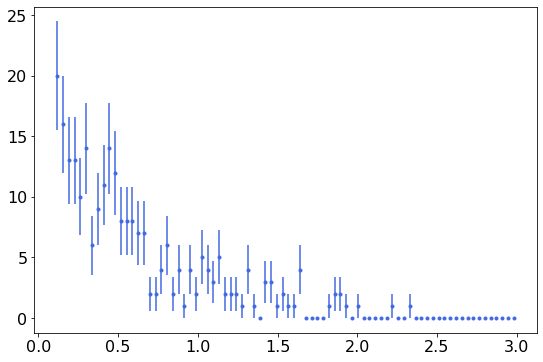

In [4]:
pltdist(data, bins=80, bounds=bounds)

In [5]:
obs = zfit.Space('x', limits=bounds)

In [6]:
lambda_ = zfit.Parameter("lambda",-2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 1., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [7]:
signal = zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1).create_extended(Nsig)
background = zfit.pdf.Exponential(obs=obs, lambda_=lambda_).create_extended(Nbkg)
tot_model = zfit.pdf.SumPDF([signal, background])

In [8]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=tot_model, data=data_) 

In [9]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [10]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)
minimum.hesse()
print(minimum)

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


------------------------------------------------------------------
| FCN = -1077                   |      Ncalls=57 (57 total)      |
| EDM = 2.88e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_3, Composed_autoparam_4] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7f9eb5183b50>] constraints=[]> 
w

Text(0, 0.5, 'number of events')

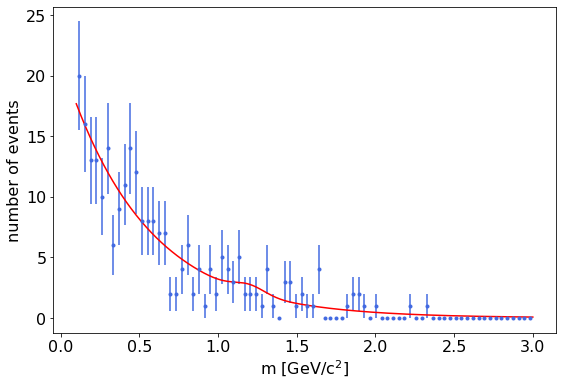

In [11]:
nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins)
plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")

### Upper limit:

Since the signal yield Nsig = $4.5 \pm 5.8$  is consistent with zero signal we compute the CLs upper limit at 95% confidence level on Nsig.

In [12]:
# instantation of the calculator
#calculator = FrequentistCalculator(nll, minimizer, ntoysnull=5000, ntoysalt=5000)
calculator = FrequentistCalculator.from_yaml("toys/upperlimit_freq_zfit_toys.yml", nll, minimizer, ntoysnull=5000, ntoysalt=5000)
calculator.bestfit = minimum #optionnal

In [13]:
# parameter of interest of the null hypothesis
poinull = POIarray(Nsig, np.linspace(0.0, 25, 15))
# parameter of interest of the alternative hypothesis
poialt = POI(Nsig, 0.)

In [14]:
# instantation of the discovery test
ul = UpperLimit(calculator, poinull, poialt)

In [15]:
ul.upperlimit(alpha=0.05, CLs=True);


Observed upper limit: Nsig = 15.814636565042779
Expected upper limit: Nsig = 11.021278424456765
Expected upper limit +1 sigma: Nsig = 15.915651887274468
Expected upper limit -1 sigma: Nsig = 8.170765582415436
Expected upper limit +2 sigma: Nsig = 21.12284985691067
Expected upper limit -2 sigma: Nsig = 5.983336289046979


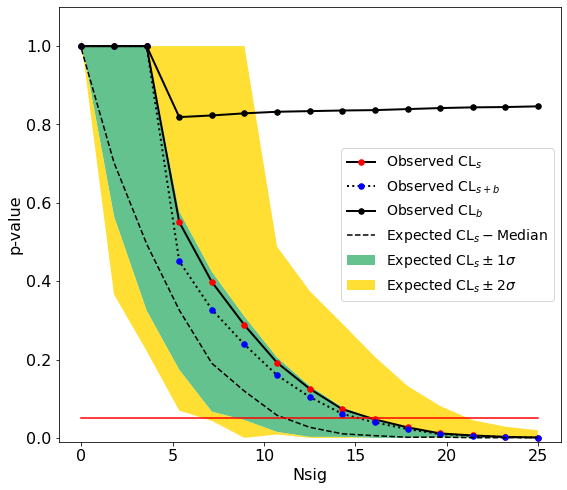

In [16]:
f = plt.figure(figsize=(9, 8))
plotlimit(ul, alpha=0.05, CLs=True)
plt.xlabel("Nsig");

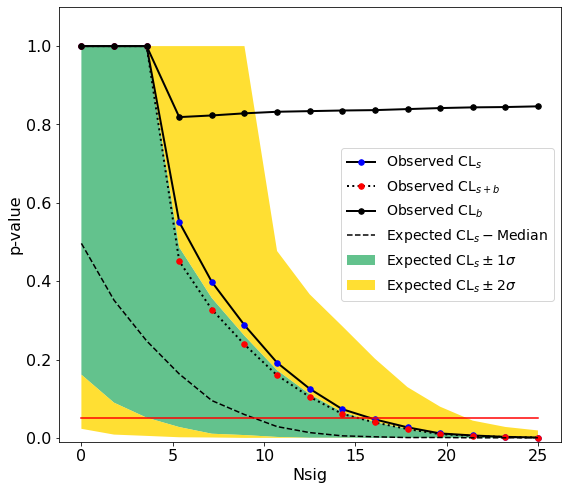

In [17]:
f = plt.figure(figsize=(9, 8))
ax = plotlimit(ul, alpha=0.05, CLs=False)
plt.xlabel("Nsig");

In [18]:
calculator.to_yaml("toys/upperlimit_freq_zfit_toys.yml")

### Illustration of the computation of the pvalues:

In the following we plot the q, the profile likelihood ratio, distributions for the null (red) and alternative hypothesis (blue) as well as the observed value q_obs.

In [19]:
qnull = calculator.qnull(poinull, poialt, onesided=True)

In [20]:
qobs = calculator.qobs(poinull, onesided=True)

In [21]:
qalt = calculator.qalt(poinull, poialt, onesided=True)

[9.29939395e-01 0.00000000e+00 1.15905286e-04 ... 0.00000000e+00
 0.00000000e+00 2.78653067e+00]
(0, nan)


ValueError: supplied range of [0, nan] is not finite

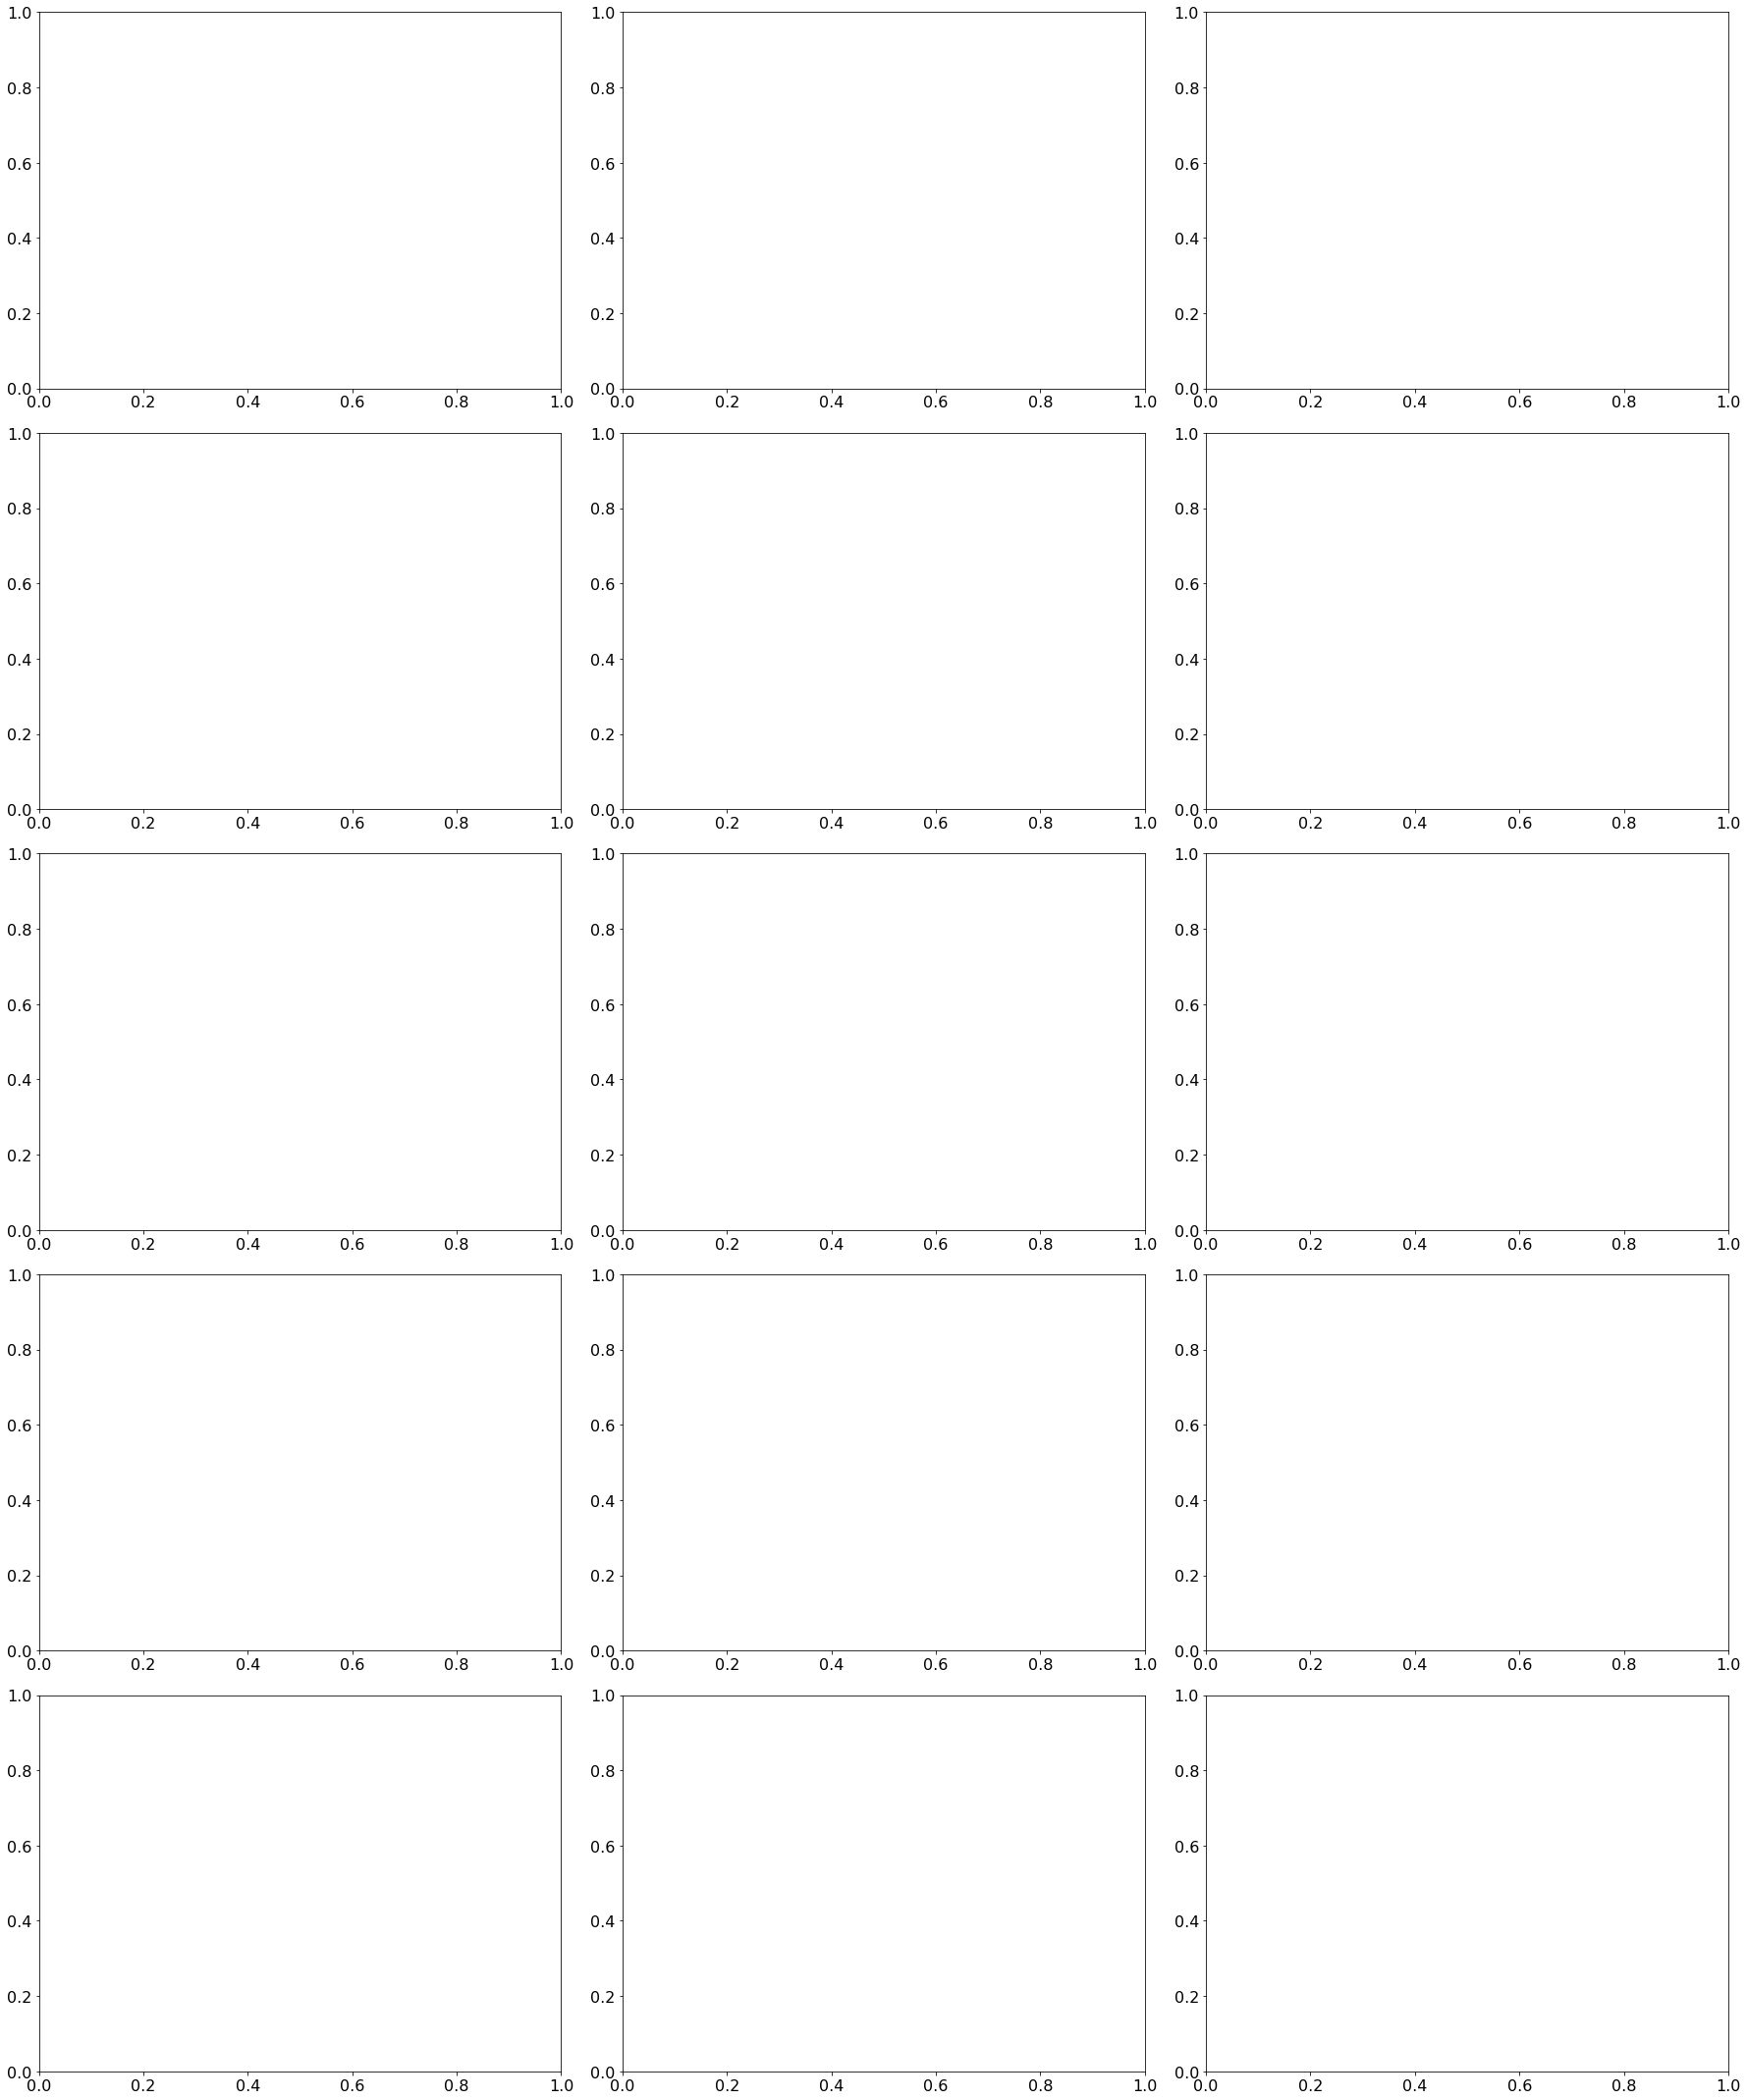

In [24]:
nbins = 30
fontsize=20

def compute_pvalue(qdist, qobs):
    qdist = qdist[~(np.isnan(qdist) | np.isinf(qdist))]
    p = len(qdist[qdist >= qobs]) / len(qdist)
    return p

f, axs = plt.subplots(5, 3, figsize=(25, 30), tight_layout=True)

for i, p in enumerate(poinull):
    
    ax = axs.flatten()[i]
    
    bounds = (0, np.percentile(qalt[p], 99.9))
    
    print(qalt[p])
    
    print(bounds)
    
    ax.hist(qnull[p], bins=nbins, label="qnull distribution", log=True, range=bounds, 
             histtype="step", color="crimson", lw=2)
    ax.hist(qalt[p], bins=nbins, label="qalt distribution", log=True, range=bounds, 
             histtype="step", color="royalblue", lw=2)
    ax.axvline(qobs[i], color="black", label="qobs", lw=2)
    ax.set_title(f"{p.name} = {p.value:.2f}")
    ax.legend(loc="best", fontsize=fontsize)
    ax.set_xlabel("q", fontsize=fontsize)  
    
    p_clsb = compute_pvalue(qnull[p], qobs[i])
    p_clb = compute_pvalue(qalt[p], qobs[i])
    p_cls = p_clsb / p_clb
    
    textstr = r"$p_{CL_{B}}$" + f"     = {p_clb:.2f}\n"
    textstr += r"$p_{CL_{S+B}}$" + f"  = {p_clsb:.2f}\n"
    textstr += r"$p_{CL_{S}}$" + f"     = {p_cls:.2f}"
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.65, 0.65, textstr, transform=ax.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)   